## Part VI: Test Model Predictions

In this section, some sample patients will be run through the SCT predictions for evaluation.

This will include:

1.  Evaluate both positive and negative predictions
2.  Compare v. Deterioration Index
3.  Compare Deterioration Index for postive and negative predictions

In [13]:
import time
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow import keras

### Load Dataset

In [2]:
LOAD_FROM_GDRIVE = True

In [3]:
# load test data only
if(LOAD_FROM_GDRIVE):
    # mount google drive to load data
    from google.colab import drive
    drive.mount('/content/drive')

    dataset_root = '/content/drive/MyDrive/Datasets/sepsis/prepared/'

    X_test = np.load(os.path.join(dataset_root, 'X_test.npy'))
    y_test = np.load(os.path.join(dataset_root, 'y_test.npy'))

else:
    # load from datalake (S3)
    !aws s3 cp $s3_datalake_path_prepared $local_data_path_csv --recursive --exclude "*" --include "*.npy"

    X_test = np.load(os.path.join(local_data_path_csv, 'X_test.npy'))
    y_test = np.load(os.path.join(local_data_path_csv, 'y_test.npy'))

Mounted at /content/drive


In [4]:
# refactor targets to work for modeling
y_test = y_test.reshape(-1,1)

### Interrogate DI v. Model Predictions (from SCT)

In [5]:
# load best SCT
best_model_sct = keras.models.load_model('/content/drive/MyDrive/Datasets/sepsis/models/xformer_cnn_tuned.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 514 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [34]:
# helper function to run prediction and return DI sequence
def predict_and_get_di_sequence(model, X):
  y_pred = model.predict(X)
  di_sequence = X[0, :, -3]
  return di_sequence, y_pred[0]

# helper function to plot DI v. Model Prediction for Single Patient
def plot_di_sequence(di_sequence, pred, title):
  fig, ax = plt.subplots(figsize=(8, 6))
  if(pred[0] > 0.5):
    plot_label = "SCT Prediction: Positive Sepsis [" + str(np.round(pred[0], 2)) + "]"
    plot_color = "red"
  else:
    plot_label = "SCT Prediction: Negative Sepsis [" + str(np.round(pred[0], 2)) + "]"
    plot_color = "green"

  sns.lineplot(x=np.arange(len(di_sequence)), y=di_sequence, color=plot_color, label=plot_label)
  sns.regplot(x=np.arange(len(di_sequence)), y=di_sequence, color=plot_color, line_kws={'linestyle': ':'}, scatter=False)
  ax.legend()
  plt.title(title)
  plt.xlabel("Time Step (hour)")
  plt.ylabel("Deterioration Index (DI)")
  plt.show()

# helper function to plot DI v. Model Prediction for a Positive and a Negative patient
def plot_di_positive_negative_sequences(positive_sequence, negative_sequence, positive_pred, negative_pred, pos_ground_truth, neg_ground_truth, title):
  fig, ax = plt.subplots(figsize=(8, 6))
  positive_label = "SCT Prediction: Positive Sepsis [" + str(np.round(positive_pred[0], 2)) + "], Ground Truth: " + str(pos_ground_truth)
  negative_label = "SCT Prediction: Negative Sepsis [" + str(np.round(negative_pred[0], 2)) + "], Ground Truth: " + str(neg_ground_truth)
  sns.lineplot(x=np.arange(len(positive_sequence)), y=positive_sequence, color='red', label=positive_label)
  sns.regplot(x=np.arange(len(positive_sequence)), y=positive_sequence, color='red', line_kws={'linestyle': ':'}, scatter=False)
  sns.lineplot(x=np.arange(len(negative_sequence)), y=negative_sequence, color='green', label=negative_label)
  sns.regplot(x=np.arange(len(negative_sequence)), y=negative_sequence, color='green', line_kws={'linestyle': ':'}, scatter=False)
  ax.legend()
  plt.title(title)
  plt.xlabel("Time Step (hour)")
  plt.ylabel("Deterioration Index (DI)")
  plt.show()

# helper function to randomly select patient and visualize DI v. SCT Prediction
def visualize_random_patient():
  rand_idx = random.randint(0, len(X_test))
  sample_patient = X_test[rand_idx:rand_idx+1]
  sample_di, sample_pred = predict_and_get_di_sequence(best_model_sct, sample_patient)
  plot_di_sequence(sample_di, sample_pred, "Det. Index Sequence v. SCT Model Prediction [" + str(rand_idx) + "]")

# helper function to run visualizations on a postive and negative patient side by side
def visualize_positive_negative_patient(pos_idx, neg_idx):
  positive_patient = X_test[pos_idx:pos_idx+1]
  positive_di, positive_pred = predict_and_get_di_sequence(best_model_sct, positive_patient)
  pos_gt = y_test[pos_idx]

  negative_patient = X_test[neg_idx:neg_idx+1]
  negative_di, negative_pred = predict_and_get_di_sequence(best_model_sct, negative_patient)
  neg_gt = y_test[neg_idx]

  plot_di_positive_negative_sequences(positive_di, negative_di, positive_pred, negative_pred, pos_gt, neg_gt, "Det. Index Sequence - Positive vs Negative Prediction [" + str(pos_idx) + " / " + str(neg_idx) + "]")

In [7]:
# get positive prediction example
sample_patient_pos = X_test[10:11]
sample_di_pos, sample_pred_pos = predict_and_get_di_sequence(best_model_sct, sample_patient_pos)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [8]:
# get negative prediction example
sample_patient_neg = X_test[0:1]
sample_di_neg, sample_pred_neg = predict_and_get_di_sequence(best_model_sct, sample_patient_neg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


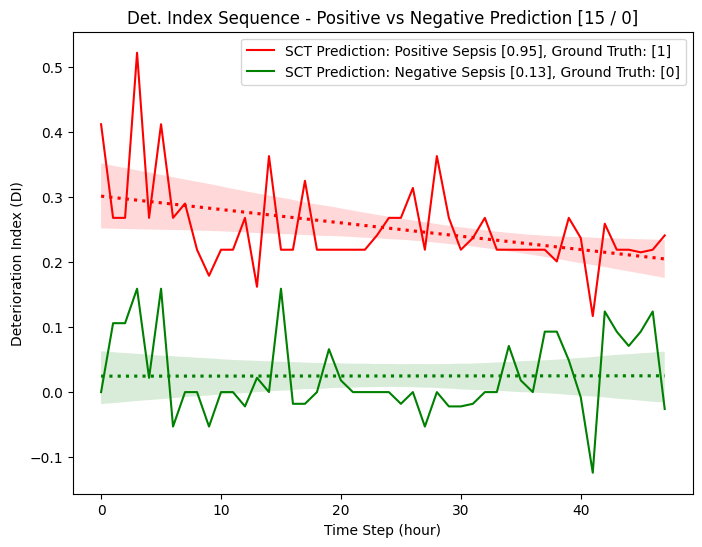

In [41]:
# plot sample positive v sample negative
visualize_positive_negative_patient(15, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


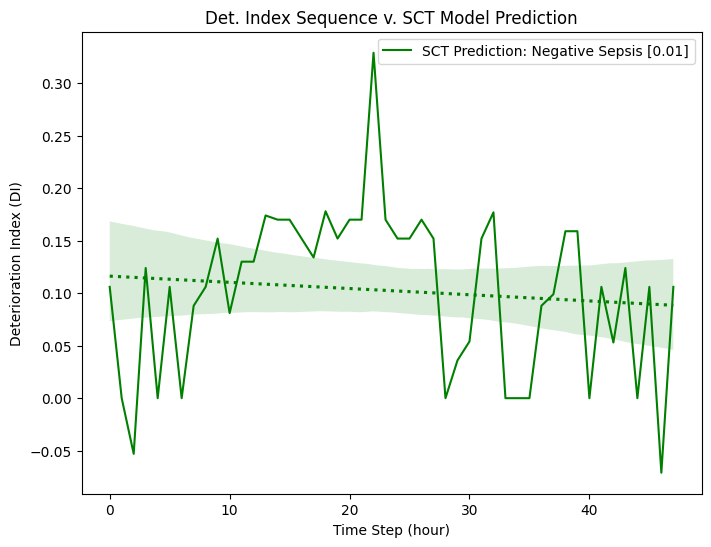

In [17]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


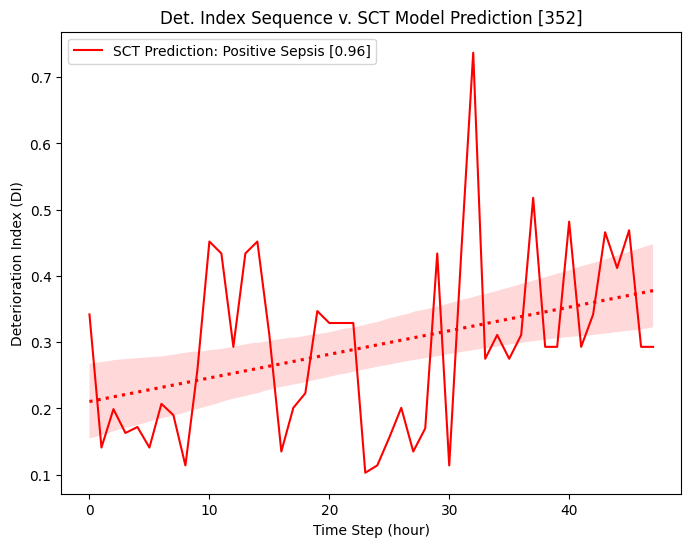

In [42]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


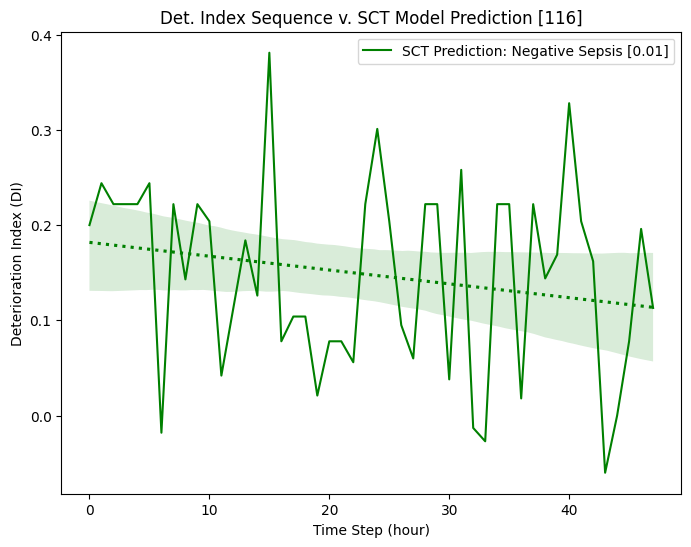

In [43]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


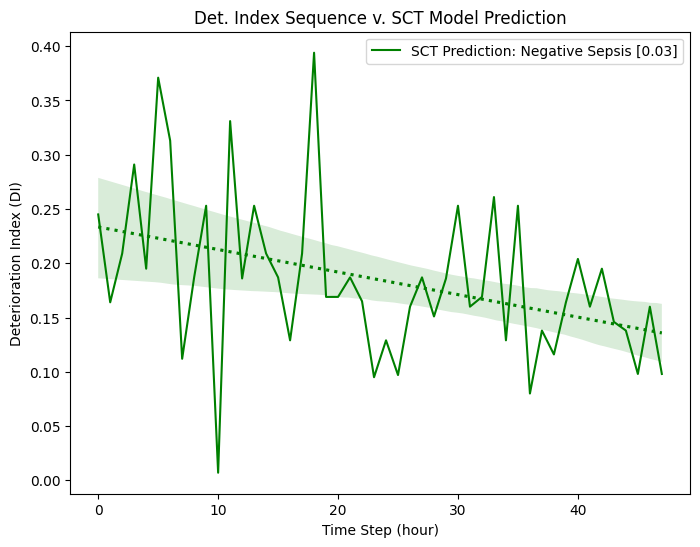

In [22]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


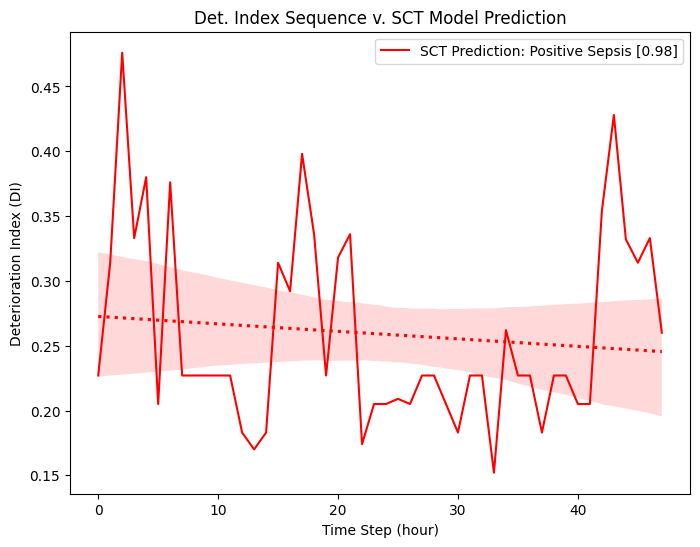

In [23]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


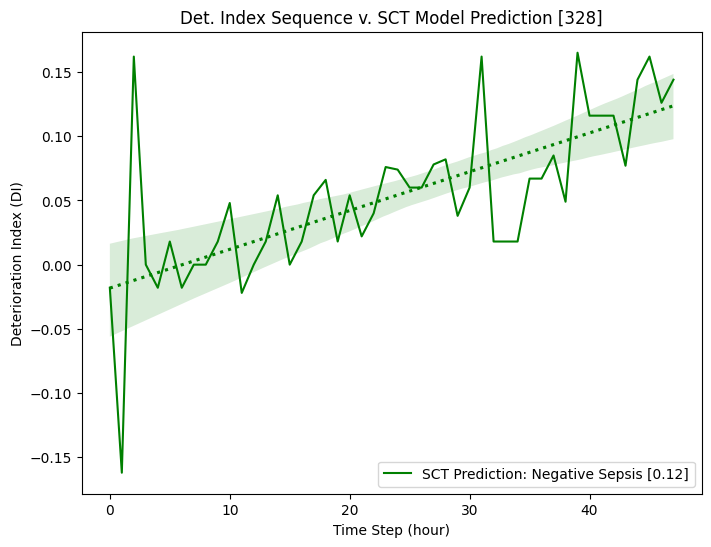

In [25]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


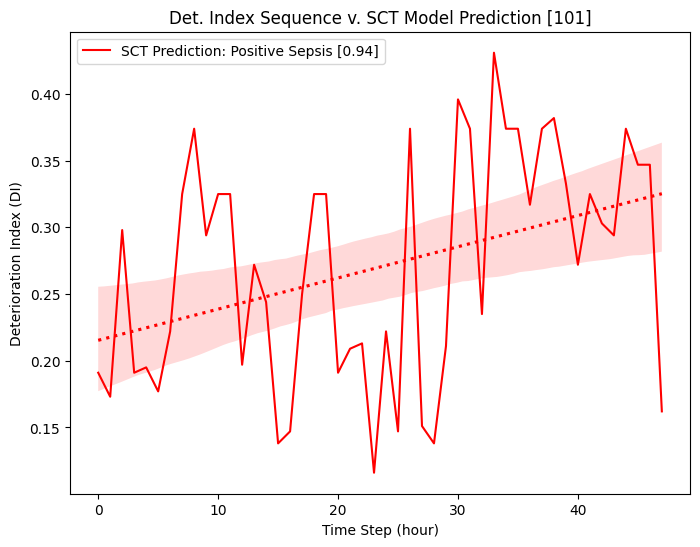

In [26]:
# test some individual preds
visualize_random_patient()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


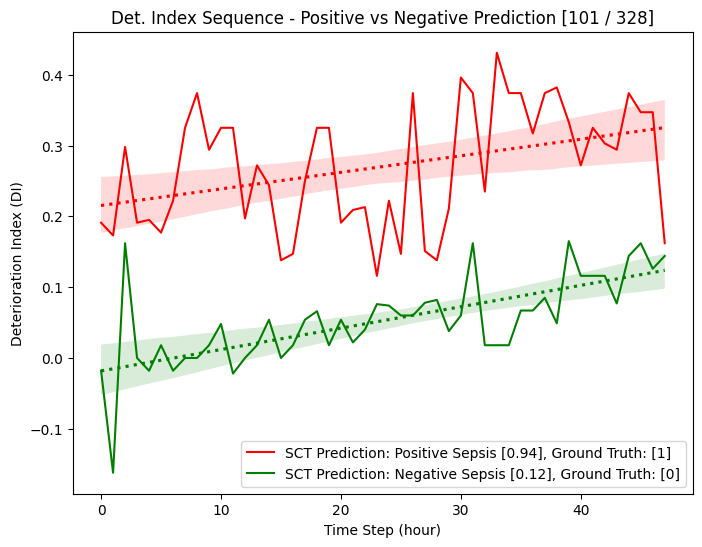

In [36]:
# show previous two side by side
visualize_positive_negative_patient(101, 328)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


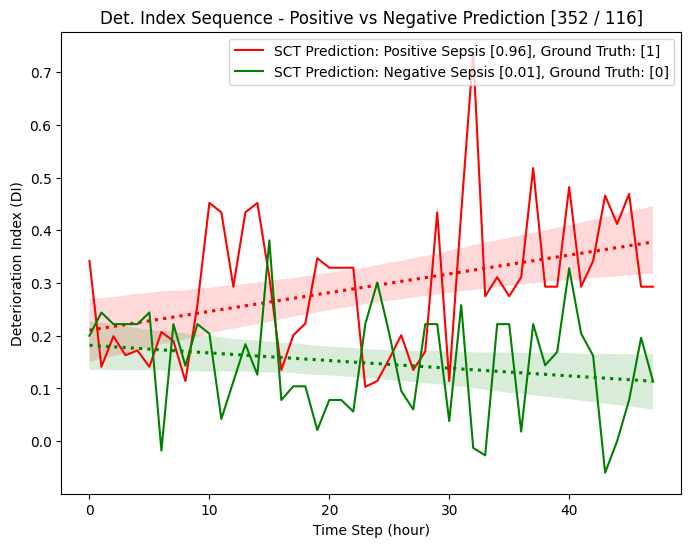

In [44]:
# show previous two side by side
visualize_positive_negative_patient(352, 116)